In [84]:
import pygsp as p
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
import cv2

In [85]:
paths = ["imgs/im_proc/cameraman.jpg", "imgs/im_proc/pikachu.png", "imgs/im_proc/small_pikachu.png"]

In [86]:
def setup(path):
    
    image = np.flip(cv2.imread(path), axis = -1)/255
    sizex, sizey = np.shape(image)[:2]
    image_flatten = image.reshape(sizex * sizey, 3).T
    
    return image, image_flatten, (sizex, sizey)

def crop(image, x, y, t):
    
    crop_image = image[y : y + t, x : x + t]
    crop_image_flatten = crop_image.reshape(t * t, 3).T
    
    return crop_image, crop_image_flatten

def make_noisy_image(path, mu = 0, sigma = 0.2):
    
    image, image_flatten, sizes = setup(path)
    sizex, sizey = np.shape(image)[:2]
    
    r_noisy = image_flatten[0] + np.random.normal(mu, sigma, size = len(image_flatten[0]))
    b_noisy = image_flatten[1] + np.random.normal(mu, sigma, size = len(image_flatten[2])) ## indices trocados para converter rgb em rbg
    g_noisy = image_flatten[2] + np.random.normal(mu, sigma, size = len(image_flatten[1])) ## indices trocados para converter rgb em rbg
    
    noises = np.array([r_noisy, b_noisy, g_noisy])
    image_noisy = noises.T.reshape(sizex, sizey, 3)
    
    return image_noisy, noises

In [243]:
i, x, y, t = 0, 92, 30, 80
mu, sigma = 0, 0.1

image, image_flatten, (sizex, sizey) = setup(paths[i])
crop_image, crop_image_flatten = crop(image, x, y, t)

image_noisy, noises = make_noisy_image(paths[i], mu, sigma)
crop_image_noisy, crop_image_noisy_flatten = crop(image_noisy, x, y, t)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


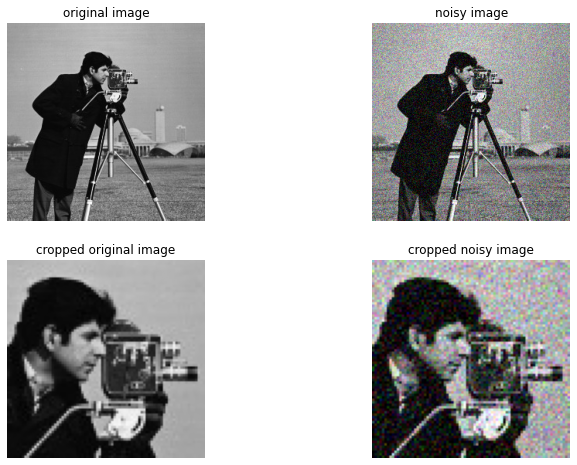

In [244]:
titles = [['original image', 'noisy image'], ['cropped original image', 'cropped noisy image']]

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
# fig, ax = plt.subplots(1, 3, figsize=(12, 8))
ax[0][0].imshow(image)
ax[1][0].imshow(crop_image)
ax[1][1].imshow(crop_image_noisy)
ax[0][1].imshow(image_noisy)

for i in [0,1]:
    for j in [0,1]:
        ax[i][j].axis('off')
        ax[i][j].set_title(titles[i][j])
# ax[2].axis('off')
plt.show()

In [245]:
def h(x, tau = 1):
    return 1. / (1. + tau * x)

def denoise_signal(G, tau, image_noisy):

    G.estimate_lmax()
    f = lambda x: h(x, tau)
    g = p.filters.Filter(G, f)
    
    sizex, sizey = np.shape(image_noisy)[:2]
    noises = image_noisy.reshape(sizex * sizey, 3).T
    r_denoised, g_denoised, b_denoised = g.filter(noises[0]), g.filter(noises[1]), g.filter(noises[2])
    image_denoised = np.array([r_denoised, g_denoised, b_denoised]).T.reshape(sizex, sizey, 3)
    
    return image_denoised

def generate_grid(image):
    
    sizex, sizey = np.shape(image)[:2]
    xs = np.linspace(0, 1, sizex)
    ys = np.linspace(0, 1, sizey)
    # full coorindate arrays
    data = np.rot90(np.array(np.meshgrid(ys, xs)).T, k = 1)
    data = data.reshape(sizex * sizey, 2)
    return data

In [246]:
1/sizex * np.sqrt(2) + 1e-4

0.005624271728019903

In [247]:
np.sqrt((1 / sizex) ** 2 + (1 / sizey) ** 2) + 1e-4

0.005624271728019903

In [248]:
data = generate_grid(image)
eps = np.sqrt((1 / sizex) ** 2 + (1 / sizey) ** 2) + 1e-4
eps = 1/sizex * np.sqrt(2) + 1e-4
# eps = 0.02301448

G = p.graphs.Grid2d(sizex, sizey)

L = p.graphs.NNGraph(Xin = data, NNtype = 'radius', epsilon = eps, center = False, rescale = False)

In [249]:
## demora muito se a imagem for grande
# image_noisy_flatten = image_noisy.reshape(sizex * sizey, 3)
# for i in range(sizex * sizey):
#     print(i)
#     for j in range(i, sizex * sizey):
#         if L.W[i,j] != 0:
#             L.W[i,j] = np.exp(-(np.linalg.norm(image_noisy_flatten[i] - image_noisy_flatten[j]))/(2 * 0.1 ** 2))

In [250]:
G.N, L.N, G.Ne, L.Ne

(65536, 65536, 130560, 260610)

In [271]:
tau = 1
G_image_denoised = denoise_signal(G, tau, image_noisy)
G_crop_image_denoised, G_crop_image_denoised_flatten = crop(G_image_denoised, x, y, t)

L_image_denoised = denoise_signal(L, tau, image_noisy)
L_crop_image_denoised, L_crop_image_denoised_flatten = crop(L_image_denoised, x, y, t)

In [272]:
sizex * sizey

65536

In [273]:
np.shape(image_noisy.reshape(sizex * sizey, 3))

(65536, 3)

In [274]:
# titles = [['original image', 'noisy image', 'denoised image'], ['cropped original image', 'cropped noisy image', 'cropped denoised image']]
titles = [['original image', 'noisy image', 'cropped noisy image'], ['original image', 'denoised image (grid)', 'cropped denoised image (grid)'], ['original image', 'cropped denoised image (grid diagonals)', 'cropped denoised image (grid diagonals)']]

# imgs = [[image, image_noisy, image_denoised], [crop_image, crop_image_noisy, crop_image_denoised]]
imgs = [[image, image_noisy, crop_image_noisy],
        [image, G_image_denoised, G_crop_image_denoised],
        [image, L_image_denoised, L_crop_image_denoised], 
        ]
# imgs = [[image, image_noisy, L_image_denoised], [image - image, image - image_noisy, image - image_denoised]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


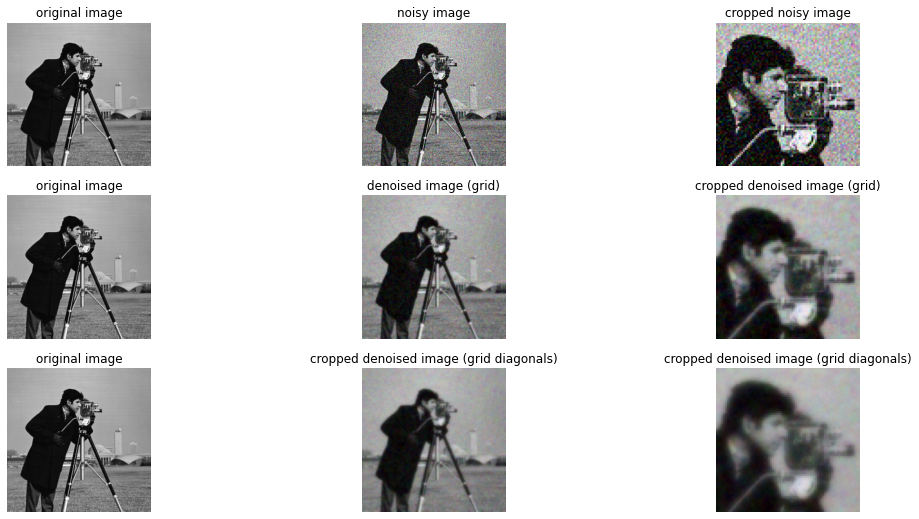

In [275]:
fig, ax = plt.subplots(3, 3, figsize = (18, 9))

for i in [0,1, 2]:
    for j in [0,1, 2]:
        ax[i][j].imshow(imgs[i][j])
        ax[i][j].axis('off')
        ax[i][j].set_title(titles[i][j])
# fig.suptitle('Usual grid graph')
plt.show()

In [12]:
xs = np.linspace(0, 1, sizex)
ys = np.linspace(0, 1, sizey)
# full coorindate arrays
data = np.rot90(np.array(np.meshgrid(ys, xs)).T, k = 1)
data = data.reshape(sizex * sizey, 2)

In [13]:
%%time
diagrams = ripser(data, thresh=1)['dgms'] #thresh é maior valor de epsilon que a função considera
## demora MUITO, fazer só com imagens pequenas

CPU times: user 4min 46s, sys: 3.02 s, total: 4min 49s
Wall time: 4min 52s


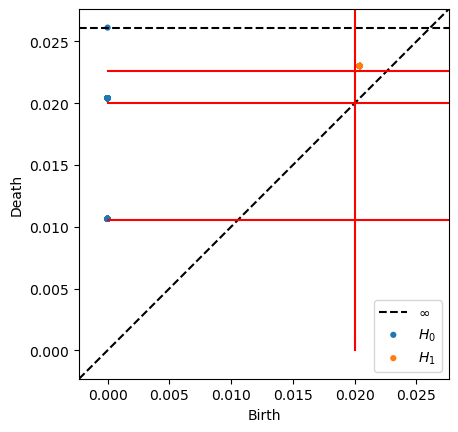

In [25]:
fig, ax = plt.subplots(1,1)
plot_diagrams(diagrams, ax = ax)
ax.plot([1/sizex, 1/sizex], [0,sizey], color = 'red')
ax.plot([0, sizex], [1/sizex,1/sizex], color = 'red')
ax.plot([0, sizex], [1/sizey,1/sizey], color = 'red')
ax.plot([0, sizex], [np.sqrt((1/sizey) ** 2 + (1/sizex) ** 2),np.sqrt((1/sizey) ** 2 + (1/sizex) ** 2)], color = 'red')


In [26]:
# eps = np.sqrt((1 / sizex) ** 2 + (1 / sizey) ** 2)
eps = 0.02301448

In [27]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)/255
gray_signal = gray_image.reshape(sizex * sizey)
noisy_gray_signal = gray_signal + np.random.normal(mu, sigma, size = sizex * sizey)

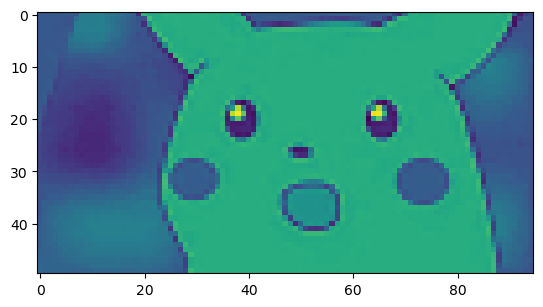

In [29]:
plt.imshow(gray_image)

In [92]:
L = p.graphs.NNGraph(Xin = data, NNtype = 'radius', epsilon = eps, center = False, rescale = False)

In [93]:
L.W.todense()[0,2]

0.9954832958622479

In [94]:
np.shape(L.W.todense()[0][0])

(1, 4750)

In [176]:
L.W

matrix([[0.        , 1.        , 1.        , ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.        , 1.        , ..., 0.        , 0.        ,
         0.        ],
        [1.        , 1.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.37516395,
         0.37516395],
        [0.        , 0.        , 0.        , ..., 0.37516395, 0.        ,
         1.        ],
        [0.        , 0.        , 0.        , ..., 0.37516395, 1.        ,
         0.        ]])

In [96]:
L.W = L.W

In [98]:
L.W

<4750x4750 sparse matrix of type '<class 'numpy.float64'>'
	with 28010 stored elements in List of Lists format>

In [100]:
L.W

matrix([[0.        , 0.99886891, 0.9954833 , ..., 0.        , 0.        ,
         0.        ],
        [0.99886891, 0.        , 0.99886891, ..., 0.        , 0.        ,
         0.        ],
        [0.9954833 , 0.99886891, 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.99886891,
         0.9954833 ],
        [0.        , 0.        , 0.        , ..., 0.99886891, 0.        ,
         0.99886891],
        [0.        , 0.        , 0.        , ..., 0.9954833 , 0.99886891,
         0.        ]])

In [102]:
M = np.zeros(np.shape(L.W))
for i in range (sizex * sizey):
    print(i)
    
    for j in range(sizex * sizey):
        
        if L.W[i,j] != 0:
            L.W[i, j] = np.exp(-(np.linalg.norm(gray_signal[i] - gray_signal[j]))/(2 * sigma ** 2))
            

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338


4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195
4196
4197
4198
4199
4200
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219
4220
4221
4222
4223
4224
4225
4226
4227
4228
4229
4230
4231
4232
4233
4234
4235
4236
4237
4238
4239
4240
4241
4242
4243
4244
4245
4246
4247
4248
4249
4250
4251
4252
4253
4254
4255
4256
4257
4258
4259
4260
4261
4262
4263
4264
4265
4266
4267
4268
4269
4270
4271
4272
4273
4274
4275
4276
4277
4278
4279
4280
4281
4282
4283
4284
4285
4286
4287
4288
4289
4290
4291
4292
4293
4294
4295
4296
4297
4298
4299
4300
4301
4302
4303
4304
4305
4306
4307
4308
4309
4310
4311
4312
4313
4314
4315
4316
4317
4318
4319
4320
4321
4322
4323
4324
4325
4326
4327
4328
4329
4330
4331
4332
4333
4334
4335
4336
4337
4338
4339
4340
4341
4342
4343
4344
4345
4346
4347
4348
4349
4350
4351
4352
4353
4354
4355
4356
4357
4358
4359
4360
4361
4362
4363
4364
4365
4366
4367
4368
4369
4370
4371
4372


In [104]:
L.W

matrix([[0.        , 1.        , 1.        , ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.        , 1.        , ..., 0.        , 0.        ,
         0.        ],
        [1.        , 1.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.37516395,
         0.37516395],
        [0.        , 0.        , 0.        , ..., 0.37516395, 0.        ,
         1.        ],
        [0.        , 0.        , 0.        , ..., 0.37516395, 1.        ,
         0.        ]])

In [105]:
np.shape(gray_signal)

(4750,)

In [108]:
G.Ne, L.Ne

(9355, 14005)

In [111]:
L.estimate_lmax()
l = p.filters.Filter(L, h)
denoised_gray_signal = l.filter(noisy_gray_signal)

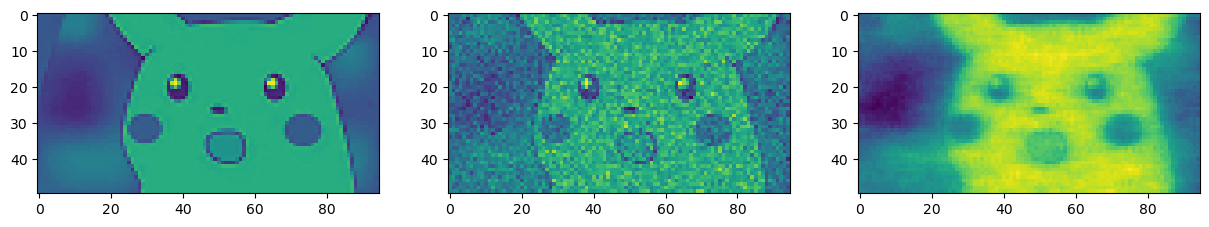

In [118]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
ax[0].imshow(gray_signal.reshape(sizex, sizey))
ax[1].imshow(noisy_gray_signal.reshape(sizex, sizey))
ax[2].imshow(denoised_gray_signal.reshape(sizex, sizey))


# L.plot_signal(gray_signal, ax = ax[0])
# L.plot_signal(noisy_gray_signal, ax = ax[1])
# L.plot_signal(denoised_gray_signal, ax = ax[2])

In [110]:
for i, eps in enumerate(np.arange(1.1/sizey, 0.2, 0.5/sizey)):
# for i, eps in enumerate([1/sizey + 1e-3, 1/sizex + 1e-3, np.sqrt((1/sizey) ** 2 + (1/sizex) ** 2) + 1e-7]):
    print(i, eps)
    L = p.graphs.NNGraph(Xin = data, NNtype = 'radius', epsilon = eps, center = False, rescale = False)
    L.estimate_lmax()
    l = p.filters.Filter(L, h)
    denoised_gray_signal = l.filter(noisy_gray_signal)
    plt.ion()
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax[0].imshow(gray_signal.reshape(sizex, sizey))
    ax[1].imshow(noisy_gray_signal.reshape(sizex, sizey))
    ax[2].imshow(denoised_gray_signal.reshape(sizex, sizey))
    titles = ['original gray image', 'noisy image', 'filtered image' + '\n' 'graph has ' + str(L.Ne) + ' edges' + '\n' 'max difference between denoised signal and original signal is ' + str(np.linalg.norm(denoised_gray_signal - gray_signal))]
    for j in [0,1,2]:
        ax[j].axis('off')
        ax[j].set_title(titles[j])
    plt.savefig("imgs/test2/" + str(i) )
    plt.close(fig)

0 0.011578947368421053
1 0.016842105263157894
2 0.022105263157894735
3 0.027368421052631577
4 0.032631578947368414
5 0.03789473684210526
6 0.0431578947368421
7 0.048421052631578934
8 0.05368421052631578
9 0.05894736842105262
10 0.06421052631578947
11 0.0694736842105263
12 0.07473684210526314
13 0.07999999999999999
14 0.08526315789473682
15 0.09052631578947366
16 0.09578947368421051
17 0.10105263157894735
18 0.1063157894736842
19 0.11157894736842103
20 0.11684210526315787
21 0.12210526315789472
22 0.12736842105263155
23 0.1326315789473684
24 0.13789473684210524
25 0.14315789473684207
26 0.14842105263157893
27 0.15368421052631576
28 0.1589473684210526
29 0.16421052631578945
30 0.16947368421052628
31 0.17473684210526313
32 0.17999999999999997
33 0.1852631578947368
34 0.19052631578947365
35 0.19578947368421049


KeyboardInterrupt: 